In [5]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [22]:
data = pd.read_csv('C:/Users/KIIT/Desktop/Research/CTR&TI/Models/dataset/The_final_dataset_1.csv')
data

,S.No.,Cocoon Weight (gm),Cocoon length(cm),mean width(cm),Cross sectional Area (cm2),Cocoon Volume (cm3),Shell Weight (gm),Category
0,1,9.35,5.01,3.01,22.14,24.7,1.45,Daba RC II
1,2,2.87,5.00,3.01,22.16,25.3,1.17,Daba RC III
2,3,8.44,5.02,3.01,22.22,25.8,1.33,Daba RC II
3,4,12.87,5.16,3.03,22.79,31.4,1.77,Daba RC I
4,5,11.28,5.00,3.13,23.29,29.0,1.44,Daba RC II
...,...,...,...,...,...,...,...,...
436,437,9.95,5.18,3.08,23.35,26.7,0.99,Daba RC III
437,438,11.98,5.22,3.20,24.74,30.9,1.55,Daba RC I
438,439,12.68,5.39,3.26,25.86,37.5,1.75,Daba RC I
439,440,11.53,5.25,2.96,22.42,29.6,1.51,Daba RC II


In [27]:
X = data[['Cocoon Volume (cm3)']].values
y = data['Shell Weight (gm)'].values

In [29]:
alpha_values = np.logspace(-3, 0, 100)
model_lasso = Lasso()
param_grid = {'alpha':alpha_values}
mse_scoring = make_scorer(mean_squared_error, greater_is_better = False)
r2_scoring = make_scorer(r2_score, greater_is_better = True)
scorers = {
    'mse': mse_scoring,
    'r2': r2_scoring
}
grid_search = GridSearchCV(estimator = model_lasso, param_grid=param_grid, cv=5, scoring=scorers, refit='r2', n_jobs=-1, verbose=2)

In [31]:
grid_search.fit(X, y)
best_alpha = grid_search.best_params_
print(f'Best alpha value: {best_alpha}')
best_lasso_model = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha value: {'alpha': 0.01519911082952934}


In [47]:

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the scores for each fold
training_errors = []
validation_errors = []
training_r2 = []
validation_r2 = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model
    best_lasso_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = best_lasso_model.predict(X_train)
    y_val_pred = best_lasso_model.predict(X_val)
    
    # Calculate and store the errors
    train_error = mean_squared_error(y_train, y_train_pred)
    # print("Mse:",train_error)
    val_error = mean_squared_error(y_val, y_val_pred)
    print("Mse:",val_error)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    training_errors.append(train_error)
    validation_errors.append(val_error)
    
    training_r2.append(train_r2)
    validation_r2.append(val_r2)

# Calculate average errors
avg_train_error = np.mean(training_errors)
avg_val_error = np.mean(validation_errors)
print(avg_val_error)

avg_train_r2 = np.mean(training_r2)
avg_val_r2 = np.mean(validation_r2)
print(avg_val_r2)
print(f'Average Training Error: {avg_train_error}')
print(f'Average Validation Error: {avg_val_error}')


print(f'Average Training Error: {avg_train_r2}')
print(f'Average Validation Error: {avg_val_r2}')



Mse: 0.05135393355417692
Mse: 0.0391348398756368
Mse: 0.0542525936840478
Mse: 0.042443422003057125
Mse: 0.039105287105998005
0.045258015244583324
0.4411379690505612
Average Training Error: 0.044442353616790574
Average Validation Error: 0.045258015244583324
Average Training Error: 0.45757295659418296
Average Validation Error: 0.4411379690505612


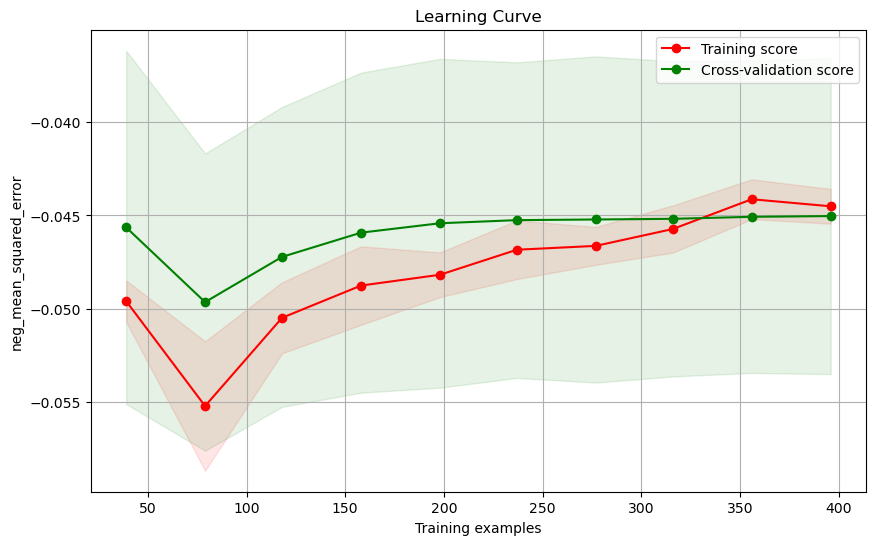

In [39]:
def plot_learning_curve(estimator, X, y, cv, scoring, n_jobs):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("neg_mean_squared_error")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

# Plotting the learning curve for Lasso regression
plot_learning_curve(best_lasso_model, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)



In [52]:
joblib.dump(best_lasso_model, "Shell_Weight_predictor_1.joblib")

['Shell_Weight_predictor_1.joblib']

In [83]:
joblib.dump(best_lasso_model, "Shell_Weight_predictor_2.joblib")

['Shell_Weight_predictor_2.joblib']